In [3]:
%pip install torch parameterfree pandas numpy scikit-learn matplotlib cloudpickle xgboost openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


### Helpful Sources about Architectures

+ If normalizing do it before activation https://forums.fast.ai/t/why-perform-batch-norm-before-relu-and-not-after/81293/4
+ What are residual networks https://arxiv.org/pdf/1512.03385.pdf
+ When building residual networks use pre-activation https://arxiv.org/abs/1603.05027
+ There is not one universal best normalization method https://proceedings.neurips.cc/paper/2021/hash/2578eb9cdf020730f77793e8b58e165a-Abstract.html
+ Adam is the standard optimizer but takes a lot of tuning. COCOB tunes automatically https://github.com/bremen79/parameterfree
+ Smaller batches tend to be better? (this seems to be with fixed epochs though so may not be relevant) https://arxiv.org/pdf/1804.07612.pdf

### Basic Architectures

In [3]:
import torch

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, norm='l'):
        super().__init__()

        if norm == 'l': norm = [torch.nn.LayerNorm  (in_features)]
        if norm == 'b': norm = [torch.nn.BatchNorm1d(in_features)]

        input_norm   = norm or []
        output_layer = torch.nn.Linear(in_features=in_features, out_features=out_features)
        self.layers  = torch.nn.Sequential(*input_norm, output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class Mlp(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(out_width) if norm == 'l' else torch.nn.BatchNorm1d(out_width)
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), norm, torch.nn.ReLU())

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.Linear(in_features=in_width, out_features=out_width), torch.nn.ReLU())

        def layer(in_width, out_width, norm):
            if norm:
                return norm_layer(in_width, out_width, norm)
            else:
                return no_norm_layer(in_width, out_width)

        width = width or in_features

        input_layer   =   layer(in_features, width       , norm)
        hidden_layers = [ layer(width      , width       , norm) for _ in range(depth) ]
        output_layer  =   torch.nn.Linear(in_features=width, out_features=out_features)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNet(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, norm='l'):
        super().__init__()        

        def norm_layer(in_width, out_width, norm):
            norm = torch.nn.LayerNorm(in_width) if norm == 'l' else torch.nn.BatchNorm1d(width)
            return torch.nn.Sequential(norm,torch.nn.ReLU(),torch.nn.Linear(in_features=in_width,out_features=out_width))

        def no_norm_layer(in_width, out_width):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Linear(in_features=in_width, out_features=out_width))

        def layer(in_width, out_width, norm):
            return norm_layer(in_width, out_width, norm) if norm else no_norm_layer(in_width, out_width)

        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, norm) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,norm),layer(in_width,in_width,norm))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,norm) for _ in range(depth)]
        output_layer  = layer(width,out_features,norm)

        self.layers  = torch.nn.Sequential(input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

class ResNetDropout(torch.nn.Module):
    def __init__(self, in_features, out_features, depth=3, width=None, drop=[.2,.5]):
        super().__init__()

        def layer(in_width,out_width,drop):
            return torch.nn.Sequential(torch.nn.ReLU(),torch.nn.Dropout(drop),torch.nn.Linear(in_features=in_width, out_features=out_width))
        
        class PreActivationResidualBlock(torch.nn.Module):
            def __init__(self, in_width, drop) -> None:
                super().__init__()
                self.layers = torch.nn.Sequential(layer(in_width,in_width,drop),layer(in_width,in_width,drop))
            def forward(self, Xs):
                return Xs+self.layers(Xs)

        width  = width or in_features

        input_layer   = torch.nn.Linear(in_features=in_features, out_features=width)
        hidden_layers = [PreActivationResidualBlock(width,drop[1]) for _ in range(depth)]
        output_layer  = layer(width,out_features,drop[1])

        self.layers  = torch.nn.Sequential(torch.nn.Dropout(drop[0]),input_layer,*hidden_layers,output_layer)

    def forward(self, Xs):
        return self.layers(Xs)

### Utility Methods

In [115]:
class hashabledict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

class Experiment:

    def __init__(self, feats, lbl, selector, scaler, ssl, batch, epoch, model, model_args, pid):
        import torch
        self._fts  = feats
        self._lbl  = lbl
        self._sel  = selector
        self._scl  = scaler
        self._ssl  = ssl
        self._b    = batch
        self._e    = epoch
        self._mod  = model
        self._args = model_args
        self._pid  = pid
        self._mse  = torch.nn.MSELoss()
        self._bce  = torch.nn.BCEWithLogitsLoss()

        hdrs = ['feats','select','scale','ssl','batch','epoch','model','model_args'      ]
        vals = [feats,str(selector),str(scaler),ssl,batch,epoch,model.__name__,model_args]
        self._key  = hashabledict(zip(hdrs,vals))
        if scaler   is None: self._key.pop('scale')
        if selector is None: self._key.pop('select')

        self._in  = None
        self._out = None

    def load_data(self):
        import numpy as np
        import pandas as pd
        import torch
        from sklearn.feature_selection import SelectKBest, f_classif

        if self._fts == 'main1' : df = pd.read_csv(f'data/sims_main1.csv')
        if self._fts == 'main2' : df = pd.read_csv(f'data/sims_main2.csv')

        if self._scl:
            for pid in set(df.participant_id):
                is_pid, is_feat = (df.participant_id==pid),(df.columns[3:])
                df.loc[is_pid,is_feat] = self._scl.fit_transform(df.loc[is_pid,is_feat])
        
        if self._ssl: X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-1).reset_index(drop=True)
        if self._ssl: Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-1).reset_index(drop=True)

        if not self._ssl: X = df
        if not self._ssl: Y = df[['participant_id','phase_id','experience_id']]

        if self._lbl == 'is_pre' : Y = pd.merge(Y,self._is_pre_df())
        if self._lbl == 'sub_anx': Y = pd.merge(Y,self._sub_anx_df())

        is_tst = Y['participant_id'] == self._pid
        is_trn = ~is_tst

        if self._sel:
            S = 3+self._sel.fit(X[is_trn].iloc[:,3:], Y[is_trn].iloc[:,-1]).get_support(indices=True)
            if X.shape[1] > 3: X = X.iloc[:,[0,1,2,*S   ]]
            if Y.shape[1] > 4: Y = Y.iloc[:,[0,1,2,*S,-1]]

        X = torch.tensor(X.iloc[:,3:].to_numpy(),dtype=torch.float)
        Y = torch.tensor(Y.iloc[:,3:].to_numpy(),dtype=torch.float)

        self._in  = X.shape[1]
        self._out = Y.shape[1]

        return (X[is_trn], Y[is_trn], X[is_tst], Y[is_tst])

    def make_model(self):
        if self._in is None: self.load_data()
        return self._mod(self._in, self._out, *self._args)

    def loss(self, Y_hat, Y_star):
        if self._ssl:
            return (self._mse(Y_hat[:,:-1],Y_star[:,:-1]) + self._bce(Y_hat[:,-1:],Y_star[:,-1:]))/2
        else:
            return self._bce(Y_hat,Y_star)

    def test_model(self, model, X_tst, Y_tst):
        scores = torch.nn.Sigmoid()(model(X_tst)[:,-1:]).squeeze().tolist()
        labels = Y_tst[:,-1:].squeeze().tolist()
        return (self._key,labels,scores)

    def _sub_anx_df(self):
        import pandas as pd

        rpt = pd.read_csv('data/self_reports.csv')
        prt = pd.read_csv('data/participants.csv')

        rpt = rpt[rpt.phase != 'baseline']
        rpt['participant_number'] = rpt['PID']
        
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        prt = prt[['participant_id','participant_number']]
    
        cols = ['experience_id','experience']
        data = [[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']]
        exp  = pd.DataFrame(data=data,columns=cols)
        
        cols = ['phase_id','phase']
        data = [[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']]
        phs  = pd.DataFrame(data=data,columns=cols)

        L = rpt[['participant_number','experience','phase','calm_anx']]
        L = pd.merge(pd.merge(pd.merge(L,exp),phs),prt)        
        L = L[['participant_id','experience_id','phase_id','calm_anx']]
        L['calm_anx'] = L['calm_anx'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})

        return L

    def _is_pre_df(self):
        import pandas as pd
        df = pd.read_csv('data/sims_labels.csv')
        df['is_pre'] = ((df['experience_id'] != 1) & (df['phase_id'] == 1)).astype(int)
        return df[['participant_id','experience_id','phase_id','is_pre']]

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps([self._fts,self._lbl,self._sel,self._scl,self._ssl,self._b,self._e,self._mod,self._args,self._pid])

    def __setstate__(self,state):
        import cloudpickle
        self.__init__(*cloudpickle.loads(state))

def all_pids():
    import pandas as pd
    return sorted(set(pd.read_csv('data/sims_labels.csv').participant_id))

def roc_plot(row,name=None):
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(*row[['labels','scores']],name=name,plot_chance_level=True).ax_.set(xlabel="FPR", ylabel="TPR")

def runner(experiments,device,maxworkers,numrepeats,show=True):
    from pandas import DataFrame
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score
    from evaluators import evaluator

    numthreads = 3 if maxworkers == 1 else 1

    pool  = ProcessPoolExecutor(max_workers=maxworkers)
    map_  = pool.map if maxworkers > 1 else map
    items = [(e,numthreads,device) for e in experiments]
    evals = {e._key:([],[]) for e,_,_ in items }

    with pool:
        for k,l,s in map_(evaluator,items*numrepeats):
            evals[k][0].extend(l)
            evals[k][1].extend(s)

    return_df = DataFrame([{**k,'auc':roc_auc_score(l,s),'labels':l,'scores':s} for k,(l,s) in evals.items()])
    styled_df = return_df.fillna('-').sort_values(by='auc',ascending=False).style.hide(["labels", "scores"],axis=1)

    if show: roc_plot(styled_df.data.iloc[0,:],"Best Classifier")
    return styled_df
    

# ---------------------- STOP ----------------------

### Hyperparameter Sweeps no SSL

CPU times: user 4.86 s, sys: 878 ms, total: 5.74 s
Wall time: 7min 50s


,feats,scale,ssl,batch,epoch,model,model_args,auc
1,main1,RobustScaler(with_scaling=False),True,256,30,ResNetDropout,"(8, 256, (0.2, 0.5))",0.671007
0,main1,RobustScaler(with_scaling=False),True,256,6,ResNet,"(4, 32, 'b')",0.641509


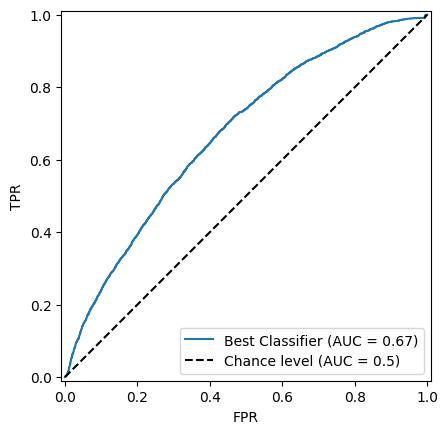

In [116]:
%%time
def experiments():
    import pandas as pd
    from itertools import product
    from sklearn.preprocessing import RobustScaler

    depths  = [4]
    widths  = [32]
    norms   = ['b']
    batches = [256]
    epochs  = [6]
    scales  = [RobustScaler(with_centering=True, with_scaling=False)]

    for a,b,e,scl,pid in product(product(depths,widths,norms),batches,epochs,scales,all_pids()):
        yield Experiment('main1', 'is_pre', None, scl, True, b, e, ResNet, a, pid)

    depths  = [8]
    widths  = [256]
    norms   = [(0.2, 0.5)]
    batches = [256]
    epochs  = [30]
    scales  = [RobustScaler(with_centering=True, with_scaling=False)]

    for a,b,e,scl,pid in product(product(depths,widths,norms),batches,epochs,scales,all_pids()):
        yield Experiment('main1', 'is_pre', None, scl, True, b, e, ResNetDropout, a, pid)

(out := runner(experiments(), 'cpu', 35, 10))

### Subjective Anxiety

In [4]:
%%time

class Sub_Experiment_SSL:

    def __init__(self, f, pid, k, key, model_maker):
        self._f   = f
        self._pid = pid
        self._k   = k
        self._key = key
        self._mse = torch.nn.MSELoss()
        self._bce = torch.nn.BCEWithLogitsLoss()
        self._mod = model_maker

    def data_load(self):
        import numpy as np
        import pandas as pd
        import torch
        from sklearn.feature_selection import SelectKBest, f_classif

        rpt = pd.read_csv('data/self_reports.csv')
        prt = pd.read_csv('data/participants.csv')
        X   = pd.read_csv(f'data/{self._f}')
        
        rpt = rpt[rpt.phase != 'baseline']
        rpt['participant_number'] = rpt['PID']
        
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        prt = prt[['participant_id','participant_number']]
    
        cols = ['experience_id','experience']
        data = [[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']]
        exp  = pd.DataFrame(data=data,columns=cols)
        
        cols = ['phase_id','phase']
        data = [[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']]
        phs  = pd.DataFrame(data=data,columns=cols)

        L = rpt[['participant_number','experience','phase','calm_anx']]
        L = pd.merge(pd.merge(pd.merge(L,exp),phs),prt)
        L = L[['participant_id','experience_id','phase_id','calm_anx']]
        
        Z = pd.merge(L,X)
        Z['calm_anx'] = Z['calm_anx'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})

        X = Z.groupby(['participant_id','phase_id','experience_id']).head(n=-1)
        X = X.reset_index(drop=True)
        Y = Z.groupby(['participant_id','phase_id','experience_id']).tail(n=-1)
        Y = Y.reset_index(drop=True)
        
        pids = Z.participant_id
        
        X_all = X.iloc[:,8:].to_numpy()
        Y_all = Y.iloc[:,8:].to_numpy()
        
        if self._k:
            selector = SelectKBest(f_classif,k=self._k).fit(X_all, Y['calm_anx'].to_numpy())
    
            X_all = selector.transform(X_all)
            Y_all = selector.transform(Y_all)
            Y_all = np.hstack([Y_all,Y[['calm_anx']].to_numpy()])
        
        
        X_all = torch.tensor(X_all).float()
        Y_all = torch.tensor(Y_all).float()
    
        X_trn = X_all[(Y.participant_id!=self._pid).tolist()]
        Y_trn = Y_all[(Y.participant_id!=self._pid).tolist()]
        X_tst = X_all[(Y.participant_id==self._pid).tolist()]
        Y_tst = Y_all[(Y.participant_id==self._pid).tolist()]
        
        return X_trn, Y_trn, X_tst, Y_tst

    def model_make(self):
        return self._mod()

    def model_loss(self, Y_hat, Y_star):
        return (self._mse(Y_hat[:,:-1],Y_star[:,:-1]) + self._bce(Y_hat[:,-1:],Y_star[:,-1:]))/2

    def model_test(self, model, X_tst, Y_tst):
        scores = torch.nn.Sigmoid()(model(X_tst)[:,-1:]).squeeze().tolist()
        labels = Y_tst[:,-1:].squeeze().tolist()
        return self._key,scores,labels

def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import E

    numthreads = 1
    maxworkers = 35

    b = 256

    args = []
    outs = defaultdict(lambda:([],[]))

    for key in product([4],[10],[(.2,.3)],[7],["sims_features1.csv"],[10]):
        d,w,n,e,f,k = key
        for pid in sorted(set(df.participant_id)):
            exp = cloudpickle.dumps(Sub_Experiment_SSL(f, pid, k, key, lambda: ResNetDropout(k,k+1,depth=d,width=w,drop=n)))
            args.extend([(exp,b,e,numthreads,device)]*10)

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(E,args):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'with_ssl',round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 569 ms, sys: 476 ms, total: 1.05 s
Wall time: 15 s


[(4, 10, (0.2, 0.3), 7, 'sims_features1.csv', 10, 'with_ssl', 0.5134)]

In [40]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval3a

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f,k in product([4,5,6],[10,20,30],[(.2,.5),(.2,.3)],[7,10,13,16],["sims_features1.csv"],[10,15]):
        model = cloudpickle.dumps(ResNetDropout(k,k+1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f,k)
        for _ in range(10):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f,k) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval3a,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'with_ssl',round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 53.7 s, sys: 10.3 s, total: 1min 4s
Wall time: 52min 8s


[(4, 10, (0.2, 0.5), 7, 'sims_features1.csv', 10, 'with_ssl', 0.412),
 (4, 10, (0.2, 0.5), 7, 'sims_features1.csv', 15, 'with_ssl', 0.333),
 (4, 10, (0.2, 0.5), 10, 'sims_features1.csv', 10, 'with_ssl', 0.4254),
 (4, 10, (0.2, 0.5), 10, 'sims_features1.csv', 15, 'with_ssl', 0.3573),
 (4, 10, (0.2, 0.5), 13, 'sims_features1.csv', 10, 'with_ssl', 0.4338),
 (4, 10, (0.2, 0.5), 13, 'sims_features1.csv', 15, 'with_ssl', 0.3064),
 (4, 10, (0.2, 0.5), 16, 'sims_features1.csv', 10, 'with_ssl', 0.471),
 (4, 10, (0.2, 0.5), 16, 'sims_features1.csv', 15, 'with_ssl', 0.4389),
 (4, 10, (0.2, 0.3), 7, 'sims_features1.csv', 10, 'with_ssl', 0.4813),
 (4, 10, (0.2, 0.3), 7, 'sims_features1.csv', 15, 'with_ssl', 0.4436),
 (4, 10, (0.2, 0.3), 10, 'sims_features1.csv', 10, 'with_ssl', 0.4783),
 (4, 10, (0.2, 0.3), 10, 'sims_features1.csv', 15, 'with_ssl', 0.4737),
 (4, 10, (0.2, 0.3), 13, 'sims_features1.csv', 10, 'with_ssl', 0.4853),
 (4, 10, (0.2, 0.3), 13, 'sims_features1.csv', 15, 'with_ssl', 0.4773),

In [20]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score
    from eval import eval3b

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([3],[20],[(.2,.5)],[5],range(1,7)):
        model = cloudpickle.dumps(ResNetDropout(n_feats,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append((model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv"))
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval3b,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'sans_ssl',roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

ValueError: not enough values to unpack (expected 10, got 9)

In [4]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score
    from eval import eval3d

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f,k in product([4],[100],[(.2,.5)],[30],[2],[10]):
        model = cloudpickle.dumps(ResNetDropout(k,1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv",k)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append((model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv",k))
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval3d,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,'sans_ssl',round(roc_auc_score(labels,scores),4)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 256 ms, sys: 389 ms, total: 644 ms
Wall time: 1min 12s


[(4, 100, (0.2, 0.5), 30, 'sims_features2.csv', 10, 'sans_ssl', 0.5344)]

In [35]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.feature_selection import SelectKBest, f_classif

    def make_data(f):
        df2 = pd.read_csv('data/self_reports.csv')
        prt = pd.read_csv('data/participants.csv')
        df3 = pd.read_csv(f'data/{f}')

        df2 = df2[df2.phase != 'baseline']
        df2['participant_number'] = df2['PID']
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        prt = prt[['participant_id','participant_number']]
        exp = pd.DataFrame([[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']],columns=['experience_id','experience'])
        phs = pd.DataFrame([[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']],columns=['phase_id','phase'])
        df2 = df2[['participant_number','experience','phase','calm_anx']]
        df2 = pd.merge(pd.merge(pd.merge(df2,exp),phs),prt)
        df2 = df2[['participant_id','experience_id','phase_id','calm_anx']]
        
        df4 = pd.merge(df2,df3)
        
        df4['calm_anx']  = df4['calm_anx'].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1})
        #df4['calm_anx']  = df4['calm_anx'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

        return df4

    for i in range(1,7):
    
        Z = make_data(f'sims_features{i}.csv')

        pids = Z.participant_id
        
        X_all = Z.iloc[:,8:].to_numpy()
        y_all = Z['calm_anx'].to_numpy()

        X_all = SelectKBest(f_classif,k=10).fit_transform(X_all, y_all)
        
        preds,trues = [],[]
        for pid in sorted(set(df.participant_id)):
        
            X_trn = X_all[pids!=pid]
            y_trn = y_all[pids!=pid]
            X_tst = X_all[pids==pid]
            y_tst = y_all[pids==pid]
    
            model = XGBClassifier(n_estimators=10,max_depth=4).fit(X_trn,y_trn)
            preds.extend(model.predict(X_tst))
            trues.extend(y_tst)
    
        print((f"sims_features{i}",balanced_accuracy_score(trues,preds)))

local()

(3117, 10)
('sims_features1', 0.49890223754452645)
(603, 10)
('sims_features2', 0.5322361723786901)
(3117, 10)
('sims_features3', 0.5086352697372819)
(603, 10)
('sims_features4', 0.4941465897522904)
(603, 10)
('sims_features5', 0.5078828534885542)
(603, 10)
('sims_features6', 0.4951906763070658)


### Pre vs Post

In [6]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.metrics import balanced_accuracy_score

    def make_data():
        df = pd.read_csv('data/sims_features.csv')
        
        X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-1)
        X = X.reset_index(drop=True)
        Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-1)
        Y = Y.reset_index(drop=True)
    
        X = X[(Y['phase_id'] != 2) & (Y['experience_id'] != 1)]
        Y = Y[(Y['phase_id'] != 2) & (Y['experience_id'] != 1)]

        return X,Y

    X,Y = make_data()
    
    pids = Y.participant_id
    
    X_all = X.iloc[:,7:].to_numpy()
    y_all = (Y['phase_id'] == 1).astype(int)

    preds,trues = [],[]
    for pid in sorted(set(df.participant_id)):
    
        X_trn = X_all[pids!=pid]
        y_trn = y_all[pids!=pid]
        X_tst = X_all[pids==pid]
        y_tst = y_all[pids==pid]

        model = XGBClassifier(n_estimators=2,max_depth=3).fit(X_trn,y_trn)
        preds.extend(model.predict(X_tst))
        trues.extend(y_tst)

    print(balanced_accuracy_score(trues,preds))
    return preds,trues

p,t = local()

0.5202978376172991


In [4]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval4

    numthreads = 1
    maxworkers = 35

    b = 16

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e in product([2],[20],[(.2,.5)],[5]):
        model = cloudpickle.dumps(ResNetDropout(n_feats,n_feats+1,depth=d,width=w,drop=n))
        key   = (d,w,n,e)
        for _ in range(5):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None) )
    
    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval4,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    return [ (*k,roc_auc_score(labels,scores)) for k,(scores,labels) in outs.items() ]

local('cpu')

CPU times: user 228 ms, sys: 295 ms, total: 522 ms
Wall time: 11.9 s


[(2, 20, (0.2, 0.5), 5, 0.48756000951992384)]

### Social/Not Social

In [59]:
def local():
    import torch
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import balanced_accuracy_score

    def make_data(f):
        df = pd.read_csv(f'data/{f}')
        return df[df.phase_id==2]

    for i in range(1,7):
        Z = make_data(f"sims_features{i}.csv")
        
        pids  = Z.participant_id
        X_all = Z.iloc[:,7:].to_numpy()
        y_all = (Z['experience_id'] == 1).astype(int)
    
        preds,trues = [],[]
        for pid in sorted(set(df.participant_id)):
        
            X_trn = X_all[pids!=pid]
            y_trn = y_all[pids!=pid]
            X_tst = X_all[pids==pid]
            y_tst = y_all[pids==pid]
    
            model = XGBClassifier(n_estimators=80,max_depth=4).fit(X_trn,y_trn)
            #model = RandomForestClassifier(n_estimators=100,ccp_alpha=.03,class_weight='balanced').fit(X_trn,y_trn)
            trues.extend(y_tst)
            preds.extend(model.predict(X_tst))
    
        print((f"sims_features{i}",balanced_accuracy_score(trues,preds)))

local()

('sims_features1', 0.7347963700291148)
('sims_features2', 0.8302146395156852)
('sims_features3', 0.6867343464454219)
('sims_features4', 0.78673637864612)
('sims_features5', 0.8222925457102672)
('sims_features6', 0.8556258790436005)


In [39]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval5

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([4],[128],[(.2,.2)],[30],[1,3]):
        model = cloudpickle.dumps(ResNetDropout(n_feats,n_feats+1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(1):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv"))

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval5,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    for k,(scores,labels) in outs.items():
        print((*k,'with_ssl',round(roc_auc_score(labels,scores),4)))
        yield (*k,scores,labels)

out = list(local('cpu'))

(4, 128, (0.2, 0.2), 30, 'sims_features1.csv', 'with_ssl', 0.9007)
(4, 128, (0.2, 0.2), 30, 'sims_features3.csv', 'with_ssl', 0.8418)
CPU times: user 357 ms, sys: 400 ms, total: 756 ms
Wall time: 15.2 s


In [5]:
%%time
def local(device):
    import cloudpickle
    from itertools import product
    from collections import defaultdict
    from concurrent.futures import ProcessPoolExecutor
    from sklearn.metrics import roc_auc_score 
    from eval import eval5

    numthreads = 1
    maxworkers = 35

    b = 256

    ins  = []
    outs = defaultdict(lambda:([],[]))

    for d,w,n,e,f in product([4],[128],[(.2,.2)],[30],[1,3]):
        model = cloudpickle.dumps(ResNetDropout(n_feats,n_feats+1,depth=d,width=w,drop=n))
        key   = (d,w,n,e,f"sims_features{f}.csv")
        for _ in range(1):
            for pid in sorted(set(df.participant_id)):
                ins.append( (model,pid,key,b,e,numthreads,device,None,f"sims_features{f}.csv"))

    with ProcessPoolExecutor(max_workers=maxworkers) as executor:
        mapper = map if maxworkers == 1 else executor.map
        for k,s,l in mapper(eval5,ins):
            outs[k][0].extend(s)
            outs[k][1].extend(l)

    for k,(scores,labels) in outs.items():
        print((*k,'with_ssl',round(roc_auc_score(labels,scores),4)))
        yield (*k,scores,labels)

out = list(local('cpu'))

(4, 128, (0.2, 0.2), 30, 'sims_features1.csv', 'with_ssl', 0.8885)
(4, 128, (0.2, 0.2), 30, 'sims_features3.csv', 'with_ssl', 0.7222)
CPU times: user 164 ms, sys: 341 ms, total: 505 ms
Wall time: 14.8 s


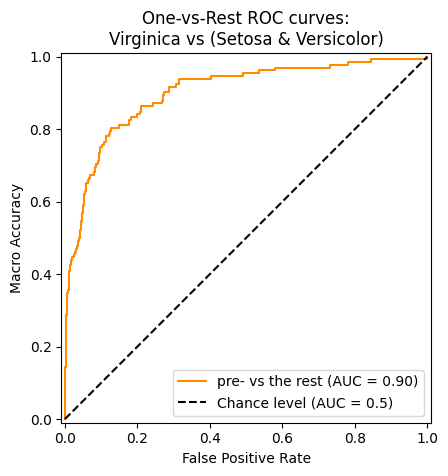

In [40]:
def local():
    from sklearn.metrics import roc_auc_score 
    import matplotlib.pyplot as plt
    
    from sklearn.metrics import RocCurveDisplay
    
    display = RocCurveDisplay.from_predictions(
        out[0][-1],
        out[0][-2],
        name=f"pre- vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="Macro Accuracy",
        title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
    )


local()

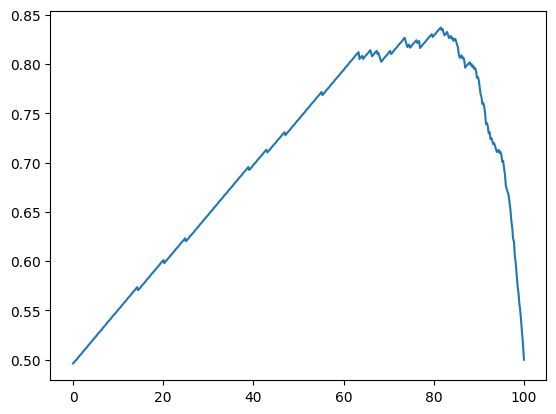

In [41]:
def local():
    from matplotlib import pyplot as plt
    from sklearn.metrics import balanced_accuracy_score
    import numpy as np

    X =  np.linspace(0,100,500)
    Y = np.percentile(out[0][-2],q=X)

    plt.plot(X,[ balanced_accuracy_score(out[0][-1], [int(s>y) for s in out[0][-2]])  for y in Y])
    
    return 
local()

In [25]:
pd.read_csv(f'data/sims_features1.csv').iloc[:,7:]

,ppg_MeanNN,ppg_SDNN,ppg_RMSSD,ppg_SDSD,ppg_CVNN,ppg_CVSD,ppg_MedianNN,ppg_MadNN,ppg_MCVNN,ppg_IQRNN,...,tmp_skin_mean,tmp_skin_std,acc_x_mean,acc_y_mean,acc_z_mean,acc_mag_mean,acc_x_std,acc_y_std,acc_z_std,acc_mag_std
0,0.677365,0.283240,1.074335,1.068997,0.000000,0.840288,1.000000,0.00,-0.376677,-0.350000,...,0.643865,0.308877,1.244814,0.576233,0.535808,-0.569641,-0.284960,-0.465764,-0.402887,-0.073688
1,0.343952,-0.788250,0.068167,0.044712,-1.514466,-0.145090,0.500000,-0.50,-0.838191,-0.750000,...,0.692725,-0.012987,1.267903,0.606498,0.502409,-0.919884,-0.319746,-0.678893,-0.358859,0.120622
2,-0.573102,-0.190304,-0.040304,-0.147672,0.004783,0.294632,-1.000000,0.00,0.000000,-0.350000,...,0.735071,0.104179,1.282214,0.611803,0.479742,-1.279335,-0.411249,-0.765804,-0.443342,-0.284621
3,-0.620891,-0.072275,0.142892,0.157800,0.239734,0.562662,-1.000000,-0.50,-0.596405,-0.350000,...,0.777416,0.307359,1.281598,0.614929,0.480125,-1.259002,-0.396724,-0.688167,-0.439620,-0.297393
4,2.676213,1.459559,2.260254,2.128079,0.568822,0.925835,4.750000,1.75,0.655390,1.050000,...,-0.651466,0.607854,0.550787,0.037986,0.647120,-0.259118,1.999371,1.571926,0.597045,1.336894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,-0.692848,-0.232688,-0.314266,-0.329774,-0.082590,0.058165,-0.551724,-0.40,-0.013881,0.000000,...,0.593626,-0.006848,-0.489200,0.206974,-1.670391,0.459998,0.120792,0.366188,1.280981,0.572019
3180,-0.921922,-0.266796,-0.192495,-0.179640,-0.013833,0.333280,-0.689655,-0.80,-0.254763,-0.695652,...,0.581019,-0.298713,-0.499840,0.174799,-1.363066,0.495339,0.340803,-0.071634,1.534307,0.272009
3181,-0.535111,0.859141,1.374024,1.349170,0.765956,1.382458,-1.103448,0.40,0.736867,0.347826,...,-0.452902,0.000000,0.644665,-0.533053,0.233384,-0.591390,-0.164294,-0.063191,-0.100670,-0.023796
3182,0.391368,0.825037,1.338595,1.446150,0.308299,0.642034,0.137931,0.40,0.316591,0.347826,...,-0.447228,-0.410983,0.619064,-0.419844,0.241415,-0.581740,-0.173906,-0.065674,-0.098363,0.000000
